# Main Project Notebook

$ A * \sin(f_{1}t +b_1)\sin(f_{2}t + b_2)$

$ A_1\sin(f_{1}t +b_1) + A_2\sin(f_{2}t + b_2)$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt\
from scipy import 
from getdata import get_data

In [49]:
day, time, height = get_data()
daydata = day['data']
timedata = time['data']
heightdata = height['data']

In [50]:
timedata=daydata*24*60 + timedata

In [51]:
for thing in (daydata,timedata,heightdata):
    print(thing)
    print()

[ 1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12
 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36
 37 37 38 38 39 39 40 40 41 41]

[ 1927  2377  3415  3865  4905  5354  6395  6840  7888  8326  9382  9811
 10884 11296 11722 12781 13207 14266 14690 15118 16171 16616 17648 18105
 19127 19585 20602 21060 22079 22534 23554 24008 25030 25481 26505 26952
 27981 28425 29457 29895 30938 31368 32425 32840 33262 34312 34738 35790
 36217 36644 37703 38155 39195 39657 40689 41150 42185 42639 43678 44127
 45170 45610 46660 47092 48150 48574 49639 50052 51130 51529 51932 53004
 53413 54480 54894 55314 56379 56835 57869 58342 59361 59834]

[ 6.57 -0.39  5.38 -1.74  5.26 -1.36  4.13 -1.15  3.48 -1.61  2.62  0.05
  1.83  1.01  3.57  0.73  4.54  2.17  3.76  2.88  3.9   1.92  4.73  1.74
  5.66  0.79  5.33 -0.04  5.23 -1.12  6.67 -0.61  4.74 -0.93  4.69 -1.29
  4.2   0.22  3.68  0.26  2.

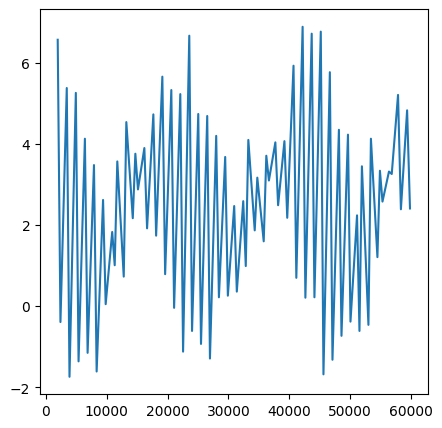

In [52]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(timedata,heightdata)